In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import shutil
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split

# Rutas iniciales
base_path = "/content/drive/MyDrive/Proyecto DVC"
images_path = os.path.join(base_path, "images")
annotations_path = os.path.join(base_path, "Annotations")

# Rutas destino en formato YOLO
yolo_base = "/content/pcb_yolo"
images_train_dir = os.path.join(yolo_base, "images", "train")
images_val_dir   = os.path.join(yolo_base, "images", "val")
labels_train_dir = os.path.join(yolo_base, "labels", "train")
labels_val_dir   = os.path.join(yolo_base, "labels", "val")

for d in [images_train_dir, images_val_dir, labels_train_dir, labels_val_dir]:
    os.makedirs(d, exist_ok=True)

# Clases (respetar el orden)
CLASSES = ["missing_hole", "mouse_bite", "open_circuit", "short", "spur", "spurious_copper"]

def convert_voc_to_yolo(size, box):
    dw = 1. / size[0]
    dh = 1. / size[1]
    x = (box[0] + box[1]) / 2.0
    y = (box[2] + box[3]) / 2.0
    w = box[1] - box[0]
    h = box[3] - box[2]
    return (x * dw, y * dh, w * dw, h * dh)

# Recorremos cada clase
all_image_label_pairs = []

for cls in CLASSES:
    img_dir = os.path.join(images_path, cls)
    ann_dir = os.path.join(annotations_path, cls)
    for img_file in os.listdir(img_dir):
        if not img_file.endswith(('.jpg', '.jpeg', '.png')):
            continue
        image_path = os.path.join(img_dir, img_file)
        xml_path = os.path.join(ann_dir, os.path.splitext(img_file)[0] + ".xml")
        if os.path.exists(xml_path):
            all_image_label_pairs.append((image_path, xml_path))

# Dividir en train y val
train_data, val_data = train_test_split(all_image_label_pairs, test_size=0.2, random_state=42)

def process_and_copy(pairs, img_dst, lbl_dst):
    for image_path, xml_path in pairs:
        filename = os.path.splitext(os.path.basename(image_path))[0]
        img_dst_path = os.path.join(img_dst, filename + ".jpg")
        lbl_dst_path = os.path.join(lbl_dst, filename + ".txt")

        # Copiar imagen
        shutil.copy(image_path, img_dst_path)

        # Procesar anotación XML
        tree = ET.parse(xml_path)
        root = tree.getroot()
        size = root.find("size")
        w = int(size.find("width").text)
        h = int(size.find("height").text)

        with open(lbl_dst_path, "w") as f:
            for obj in root.iter("object"):
                cls = obj.find("name").text
                if cls not in CLASSES:
                    continue
                cls_id = CLASSES.index(cls)
                xmlbox = obj.find("bndbox")
                b = (
                    float(xmlbox.find("xmin").text),
                    float(xmlbox.find("xmax").text),
                    float(xmlbox.find("ymin").text),
                    float(xmlbox.find("ymax").text)
                )
                bb = convert_voc_to_yolo((w, h), b)
                f.write(f"{cls_id} {' '.join(f'{a:.6f}' for a in bb)}\n")

# Procesar train y val
process_and_copy(train_data, images_train_dir, labels_train_dir)
process_and_copy(val_data, images_val_dir, labels_val_dir)

print("Dataset listo en formato YOLO en:", yolo_base)


Dataset listo en formato YOLO en: /content/pcb_yolo


In [3]:
!pip install ultralytics


In [4]:
# Ruta base del dataset
dataset_dir = "/content/pcb_yolo"

# Lista de clases (debe coincidir exactamente con el orden usado antes)
class_names = ["missing_hole", "mouse_bite", "open_circuit", "short", "spur", "spurious_copper"]

# Contenido del archivo data.yaml
yaml_content = f"""path: {dataset_dir}
train: images/train
val: images/val
names: {class_names}
nc: {len(class_names)}
"""

# Guardar el archivo
with open(os.path.join(dataset_dir, "data.yaml"), "w") as f:
    f.write(yaml_content)

print(" Archivo data.yaml creado en:", os.path.join(dataset_dir, "data.yaml"))


 Archivo data.yaml creado en: /content/pcb_yolo/data.yaml


In [5]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")
model.train(data="/content/pcb_yolo/data.yaml", epochs=50, imgsz=640, batch=16)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/pcb_yolo/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f229c519280>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
     


image 1/1 /content/pcb_yolo/images/val/08_missing_hole_04.jpg: 512x640 4 missing_holes, 85.6ms
Speed: 8.4ms preprocess, 85.6ms inference, 2.1ms postprocess per image at shape (1, 3, 512, 640)


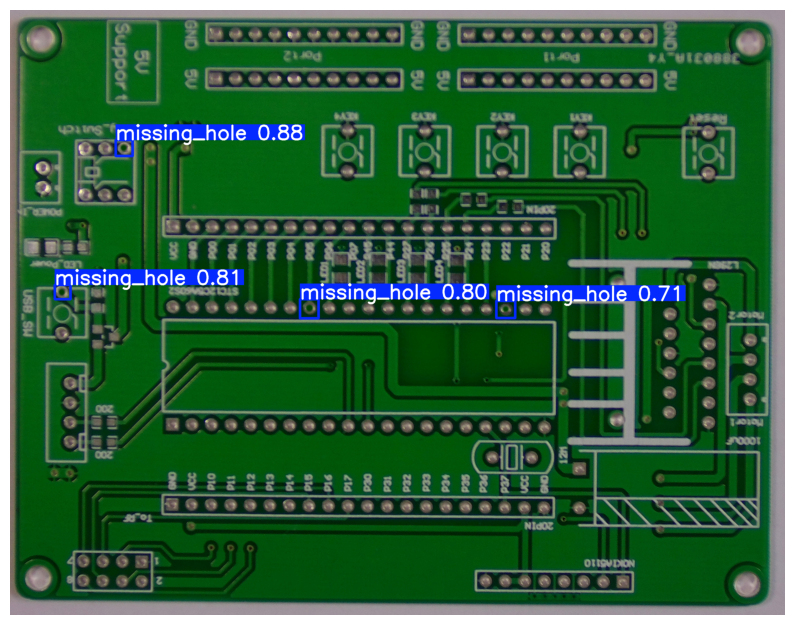

In [8]:
# Importar la librería para mostrar imágenes
from PIL import Image
import matplotlib.pyplot as plt

# Cargar el modelo entrenado
model = YOLO("/content/runs/detect/train/weights/best.pt")

# Ruta de la imagen de prueba
image_path = "/content/pcb_yolo/images/val/08_missing_hole_04.jpg"

# Realizar la predicción
results = model.predict(source=image_path, conf=0.25) # Ajusta el umbral de confianza si es necesario

# Mostrar la imagen con las predicciones
for r in results:
    im_array = r.plot()  # Obtener la imagen con las detecciones dibujadas
    im = Image.fromarray(im_array[..., ::-1])  # Convertir a imagen PIL
    plt.figure(figsize=(10, 10))
    plt.imshow(im)
    plt.axis('off')
    plt.show()


In [ ]:
!pip install --upgrade ultralytics